# Lecture 9 - Decision Trees and Random Forests

Decision tree classifiers are attractive models if we care about interpretability. As the name “decision tree” suggests, we can think of this model as breaking down our data by making a decision based on asking a series of questions.

In [1]:
from IPython.display import Image
%matplotlib inline

# Decision tree learning

Let us consider the following example in which we use a decision tree to decide upon an activity on a
particular day.

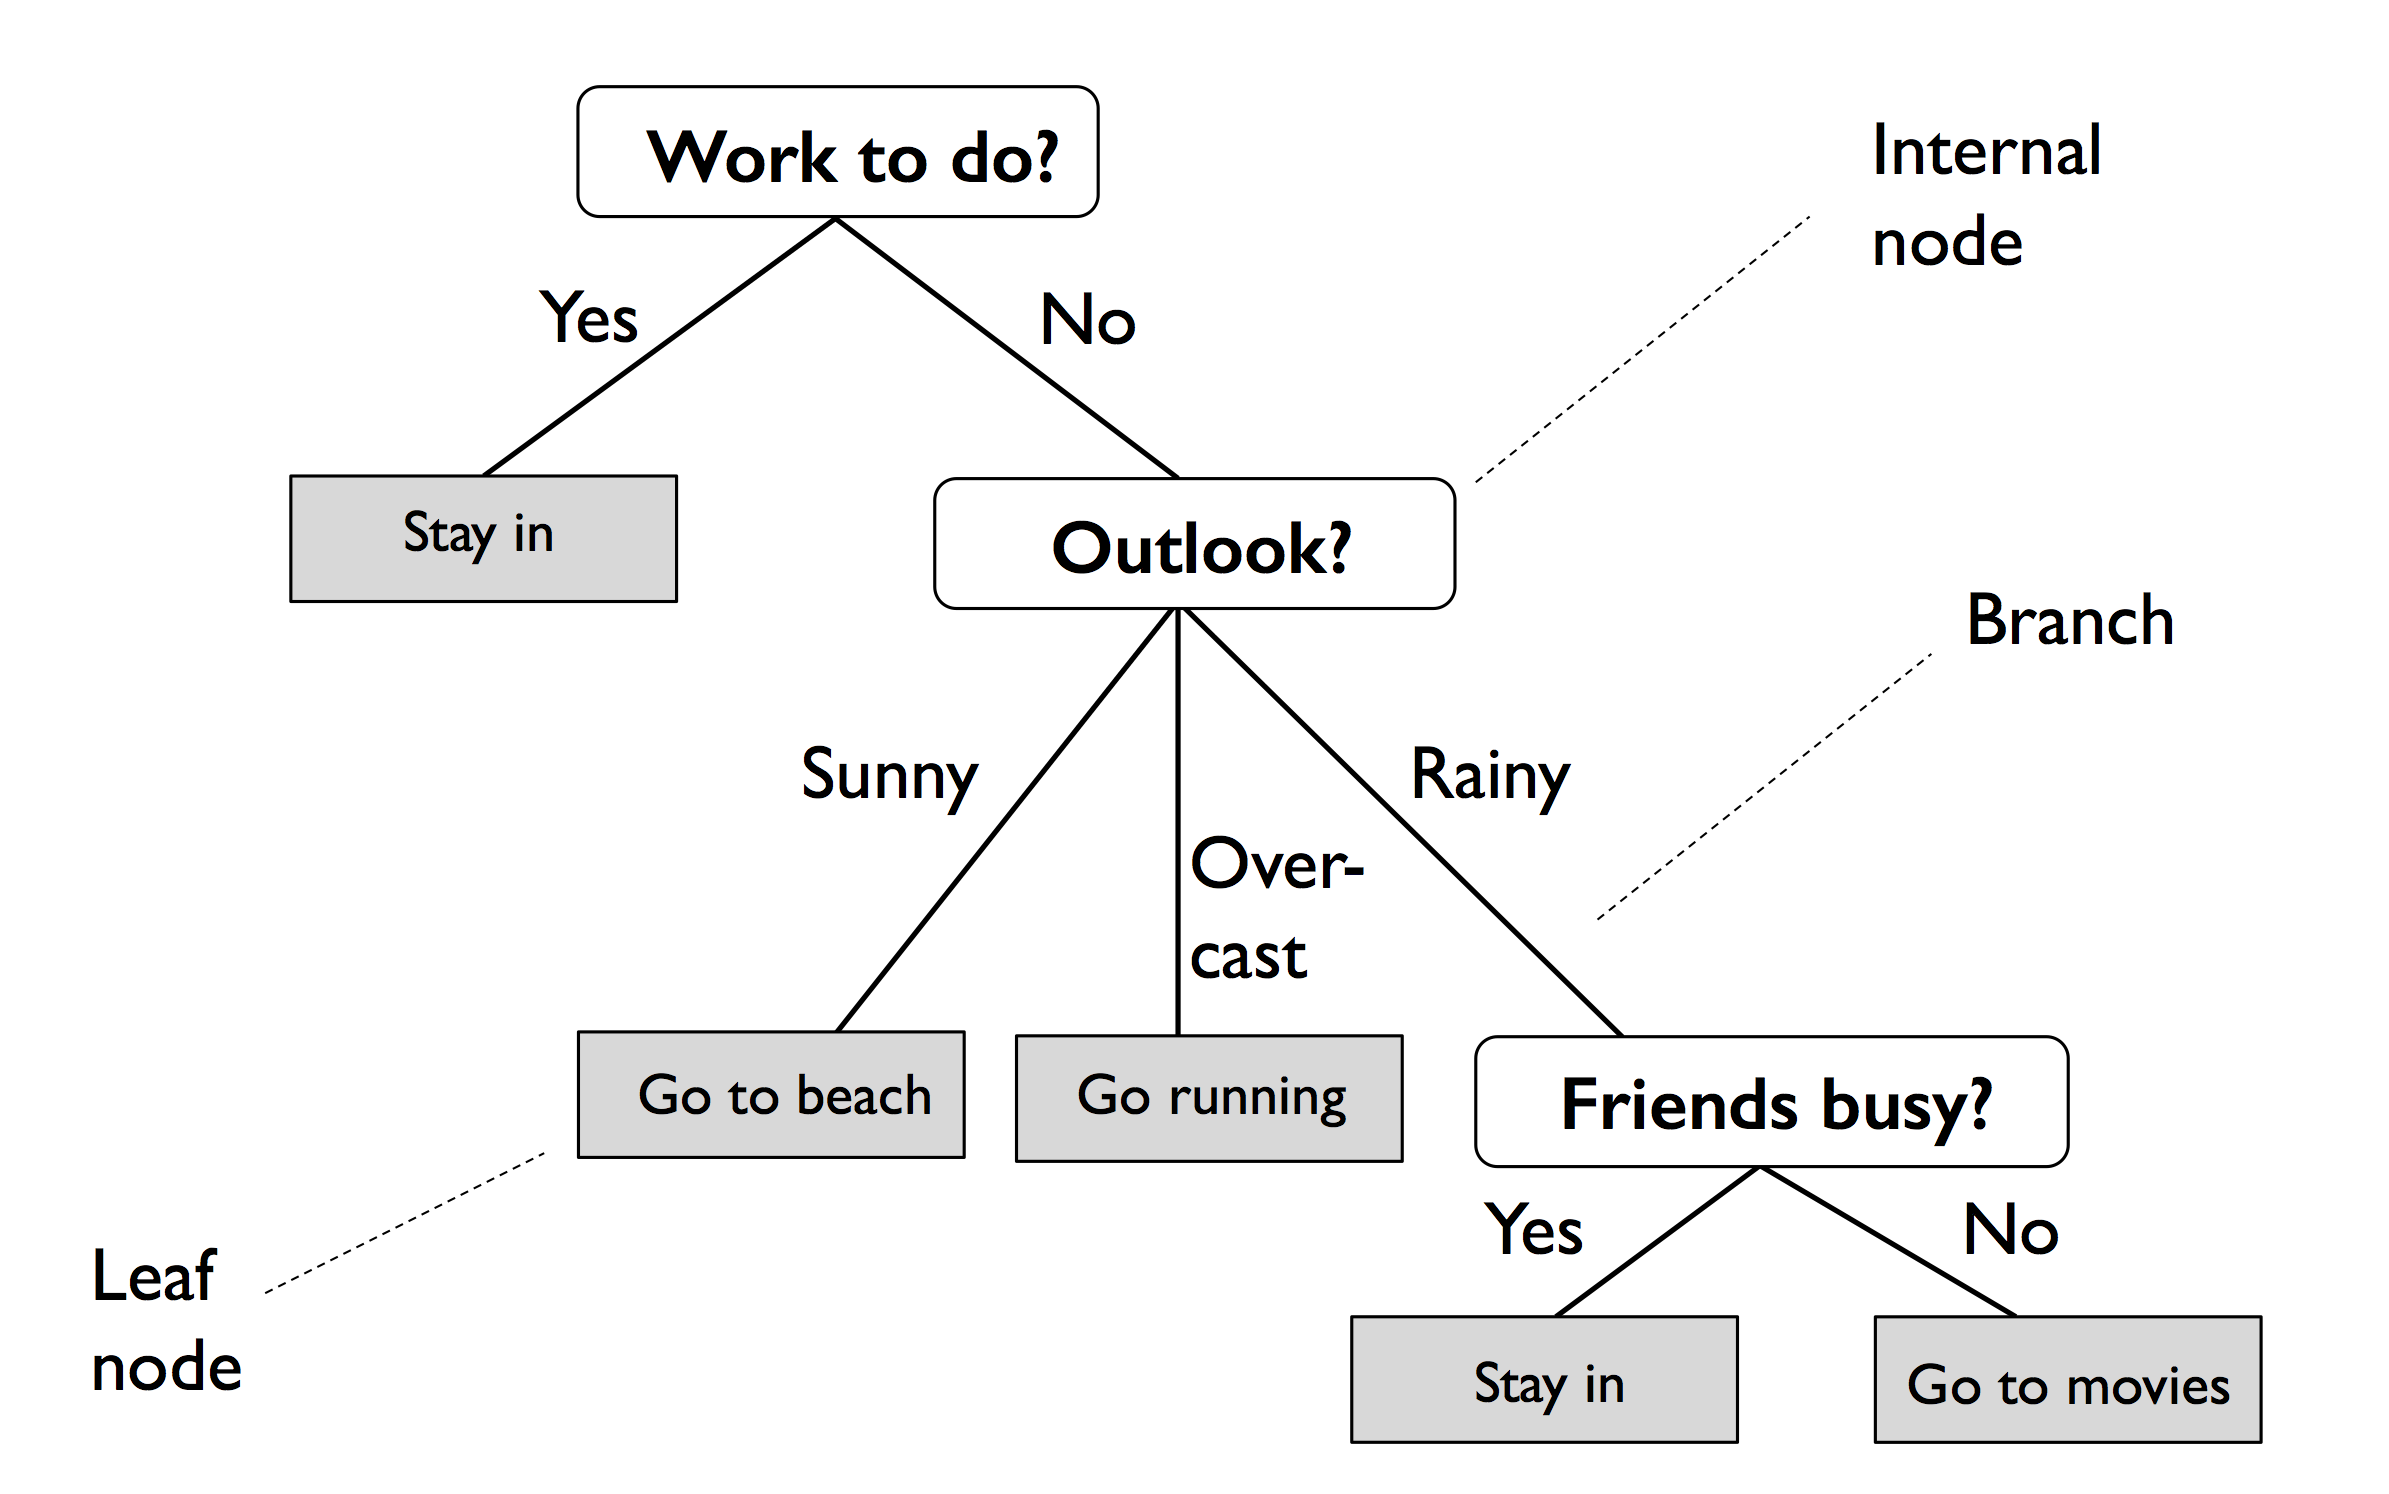

In [2]:
Image(filename='figures/03_17.png', width=500) 

Based on the features in our training dataset, the decision tree model learns a series of questions to
infer the class labels of the examples.

Although the example above illustrates the concept of a decision tree based on categorical variables, the same concept applies if our features are real numbers, like in the Iris dataset. 

For example, we could simply define a cut-off value along the **sepal width** feature axis
and ask a binary question: “Is the sepal width $\geq$ 2.8 cm?”

Using the decision algorithm, we start at the tree root and split the data on the feature that results in the largest **information gain (IG)**.

In an iterative process, we can then repeat this splitting procedure at each child node until the leaves are *pure*. This means that the training examples at each terminal node all belong to the same class.

In practice, this can result in a very deep tree with many nodes, which can easily lead to *overfitting*. Thus, we typically want to prune the tree by setting a limit for the maximum depth of the tree.

## Maximising information gain - getting the most bang for the buck

To split the nodes at the most informative features, we need to define an objective function to optimise via the tree learning algorithm.

Here, our objective function is to maximize the IG at each split, which
we define as follows:

$$
IG(D_p,f)  = I(D_p) - \sum^m_{j=1} \frac{N_j}{N_p} I(D_j).
$$

Here, 
- $f$ is the feature to perform the split; 
- $D_p$ and $D_j$ are the dataset of the parent and $j$th child node; 
- $I$ is the **impurity** measure; 
- $N_p$ is the total number of training examples at the parent node; and,
- $N_j$ is the number of examples in the $j$th child node. 

As we can see, the information gain is simply the difference between the impurity of the parent node and the sum of the child node impurities—the lower the impurities of the child nodes, the larger the information gain. 

However, for simplicity and to reduce the combinatorial search space, most libraries (including scikit-learn) implement binary decision trees. This means that each parent node is split into two child nodes, $D_{left}$ and $D_{right}$. The IG is then given as

$$
IG(D_p,f)  = I(D_p) - \frac{N_{left}}{N_p} I(D_{left}) - \frac{N_{right}}{N_p} I(D_{right}).
$$

The three impurity measures or splitting criteria that are commonly used in binary decision trees
are **Gini impurity ($I_G$)**, **entropy ($I_H$)**, and the **classification error ($I_E$)**.

**Entropy for all non-empty classes** $(p(i|t) \neq 0):$

$$
I_H(t) = -\sum^c_{i=1}p(i|t) \log_2 p(i|t).
$$

- p(i|t) is the proportion of the examples that belong to class $i$ for a particular node $t$.

The entropy is 0 if all examples at a node belong to the same class, and the entropy is maximal if we have a uniform class distribution.

For example, in a binary class setting, the entropy is 0 if $p(i=1|t) = 1$ or
$p(i=0|t) = 0$. 

If the classes are distributed uniformly with $p(i=1|t) = 0.5$ and $p(i=0|t) = 0.5$, the entropy
is 1. 

Therefore, the entropy criterion attempts to maximise the mutual information in the tree.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

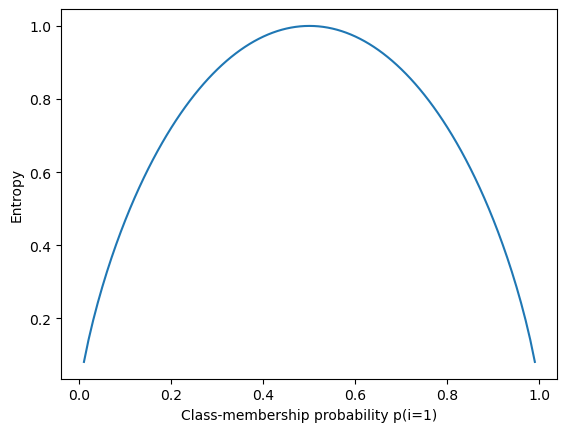

In [4]:
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None 
       for p in x]

plt.ylabel('Entropy')
plt.xlabel('Class-membership probability p(i=1)')
plt.plot(x, ent)
#plt.savefig('figures/03_26.png', dpi=300)
plt.show()

The **Gini impurity ($I_G$)** can be understood as a criterion to minimise the probability of misclassification:

$$
I_G(t) = \sum^c_{i=1} p(i|t) (1- p(i|t)) = 1 - \sum^c_{i=1}p(i|t)^2.
$$

Similar to entropy, the Gini impurity is maximal if the classes are perfectly mixed, for example, in a
binary class setting ($c = 2$):

$$
I_G(t) = 1 - \sum^c_{i=1}0.5^2 = 0.5.
$$

However, in practice, both the Gini impurity and entropy typically yield very similar results.

Another impurity measure is the **classification error**:

$$
I_E(t) = 1 - \max\{p(i|t)\}.
$$

This is a useful criterion for pruning, but not recommended for growing a decision tree, since it is
less sensitive to changes in the class probabilities of the nodes. 

We can illustrate this by looking at the two possible splitting scenarios shown below:

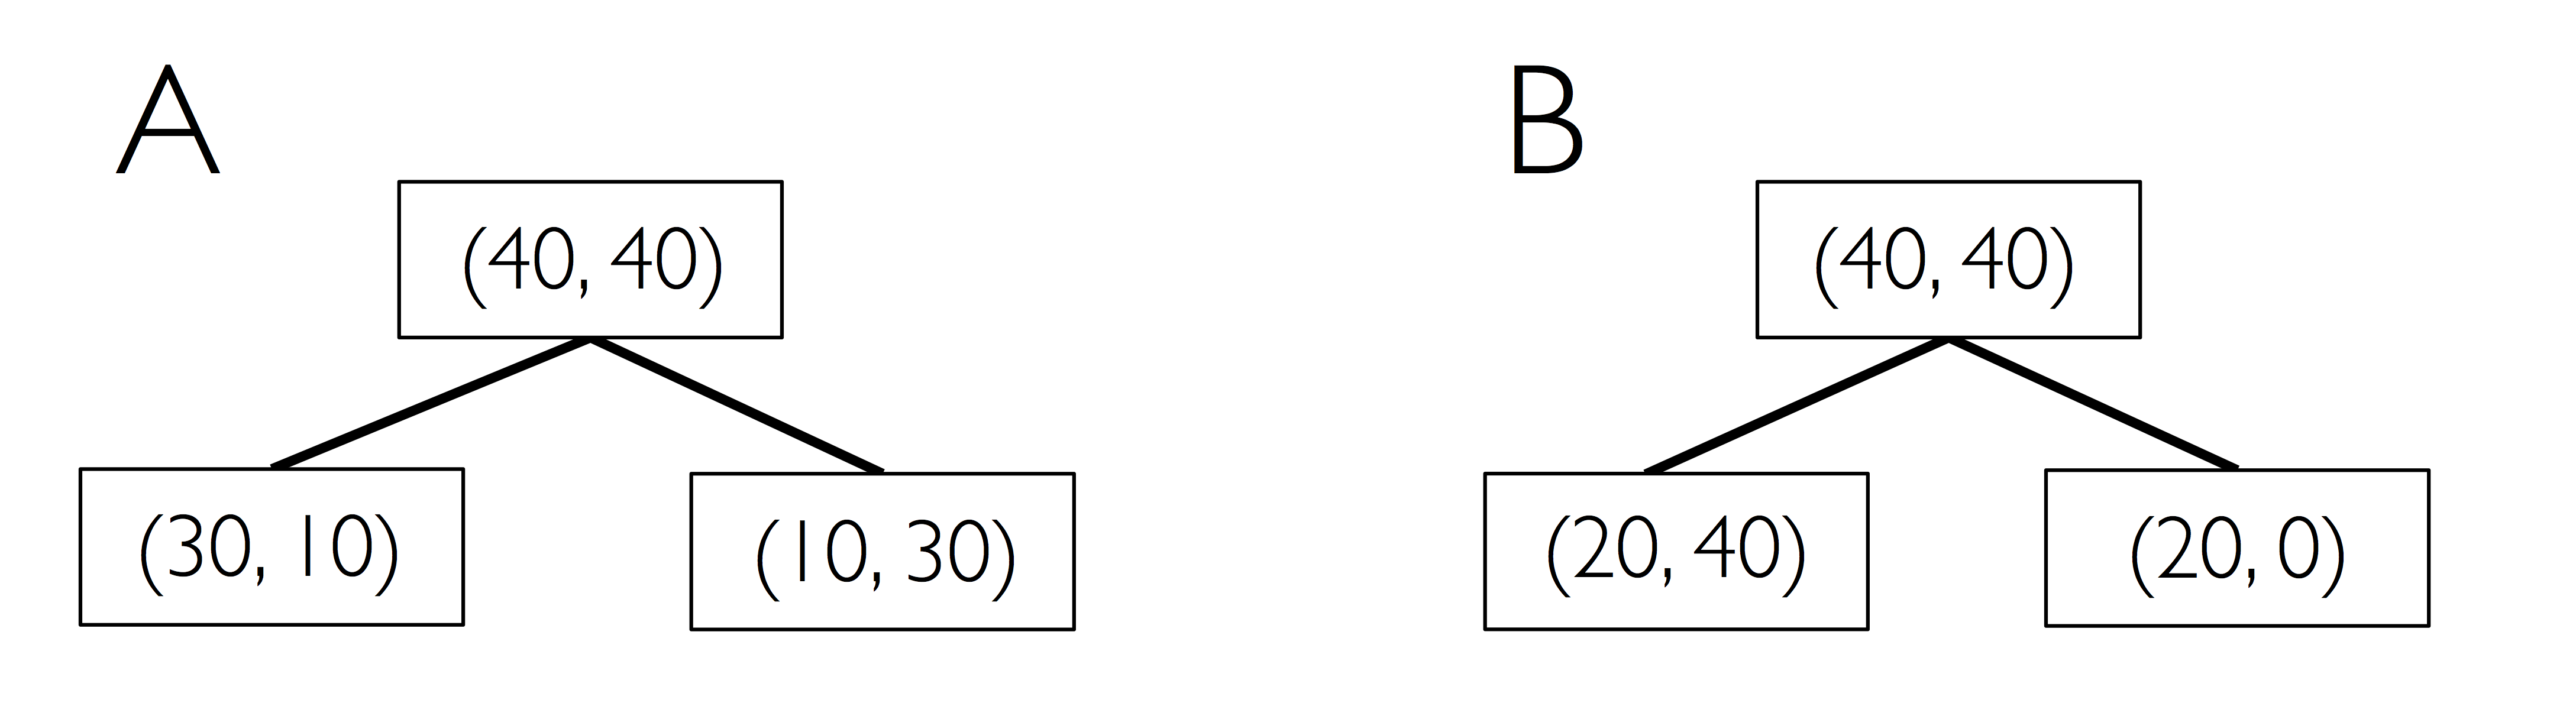

In [5]:
Image(filename='figures/03_18.png', width=500) 

We start with a dataset, $D_p$, at the parent node, which consists of 40 examples from class 1 and 40
examples from class 2 that we split into two datasets, $D_{left}$ and $D_{right}$. 

Let us compute the information gain using the classification error in both scenarios, A and B. At the parent node $I_E(D_p) = 1 - 0.5 = 0.5.$

A: $I_E (D_{left}) = 1 - \frac{3}{4} = 0.25.$

A: $I_E (D_{right}) = 1 - \frac{3}{4} = 0.25.$

A: $IG_E = 0.5 - \frac{4}{8} 0.25 - \frac{4}{8} 0.25 = 0.25.$

B: $I_E (D_{left}) = 1 - \frac{4}{6} = \frac{1}{3}.$

B: $I_E (D_{right}) = 1 - 1 = 0.$

B: $IG_E  = 0.5 - \frac{6}{8} \times \frac{1}{3} - 0 = 0.25.$


However, the Gini impurity would favour the split in scenario B which is indeed purer:

$I_G(D_p) = 1 - (0.5^2 + 0.5^2) = 0.5.$

A: $I_G (D_{left}) = 1 - \Bigl(\bigl(\frac{3}{4}\bigr)^2 + \bigl(\frac{1}{4}\bigr)^2 \Bigr) = \frac{3}{8} = 0.375.$

A: $I_G (D_{right}) = 1 - \Bigl(\bigl(\frac{1}{4}\bigr)^2 + \bigl(\frac{3}{4}\bigr)^2 \Bigr) = 0.375.$

A: $IG_G = 0.5 - \frac{4}{8} 0.375 - \frac{4}{8} 0.375 = 0.125.$

B: $I_G (D_{left}) = 1 - \Bigl(\bigl(\frac{2}{6}\bigr)^2 + \bigl(\frac{4}{6}\bigr)^2 \Bigr) = \frac{4}{9} = 0.\overline{4}.$

B: $I_G (D_{right}) = 1 - \Bigl(1^2 + 0^2 \Bigr) = 0.$

B: $IG_G = 0.5 - \frac{6}{8} 0.\overline{4} -0 = 0.1\overline{6}.$


Similarly, the entropy criterion would also favor scenario B over scenario A.

$I_H(D_p) = -(0.5 \log_2 (0.5) + 0.5 \log_2 (0.5)) = 1.$

A: $I_H (D_{left}) = -\Bigl(\frac{3}{4}\log_2\bigl(\frac{3}{4}\bigr) + \frac{1}{4}\log_2\bigl(\frac{1}{4}\bigr)\Bigr) = 0.81.$

A: $I_H (D_{right}) = -\Bigl(\frac{1}{4}\log_2\bigl(\frac{1}{4}\bigr) + \frac{3}{4}\log_2\bigl(\frac{3}{4}\bigr)\Bigr) = 0.81.$

A: $IG_H = 1 - \frac{4}{8} 0.81 - \frac{4}{8} 0.81 = 0.125.$

B: $I_H (D_{left}) = -\Bigl(\frac{2}{6}\log_2\bigl(\frac{2}{6}\bigr) + \frac{4}{6}\log_2\bigl(\frac{4}{6}\bigr)\Bigr) = 0.92.$

B: $I_H (D_{right}) = 0.$

B: $IG_G = 1 - \frac{6}{8} 0.92 -0 = 0.31.$


For a more visual comparison of the three different impurity criteria that we discussed previously,
let us plot the impurity indices for the probability range [0, 1] for class 1. 

Note that we will also add a scaled version of the entropy (entropy / 2) to observe that the Gini impurity is an intermediate measure between entropy and the classification error.

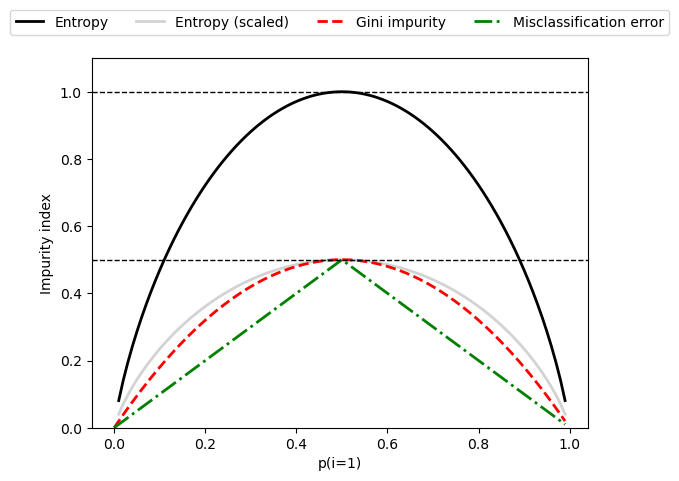

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini impurity', 'Misclassification error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity index')
#plt.savefig('figures/03_19.png', dpi=300, bbox_inches='tight')
plt.show()

## Building a decision tree

Decision trees can build complex decision boundaries by dividing the feature space into rectangles.

However, we have to be careful since the deeper the decision tree, the more complex the decision
boundary becomes, which can easily result in overfitting. 

Using scikit-learn, we now train a decision tree with a maximum depth of 4, using the Gini impurity as a criterion for impurity.

Although feature scaling may be desired for visualisation purposes, note that feature scaling is not a
requirement for decision tree algorithms

In [43]:
import pandas as pd
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [45]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [46]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [47]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set')        

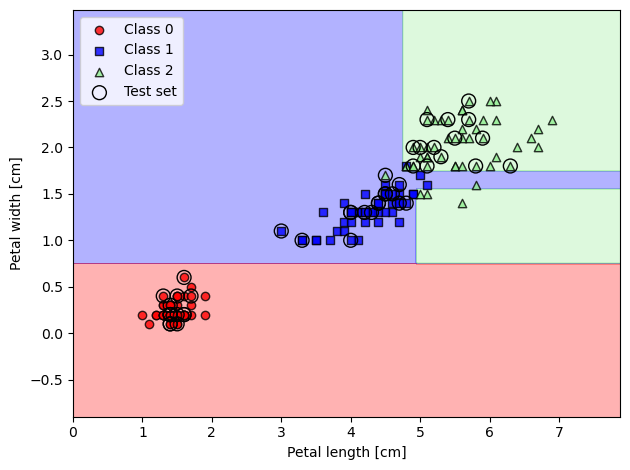

In [54]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=5, 
                                    random_state=1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_model,
                      test_idx=range(105, 150))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

We can readily visualise the decision tree model after training via the following code:

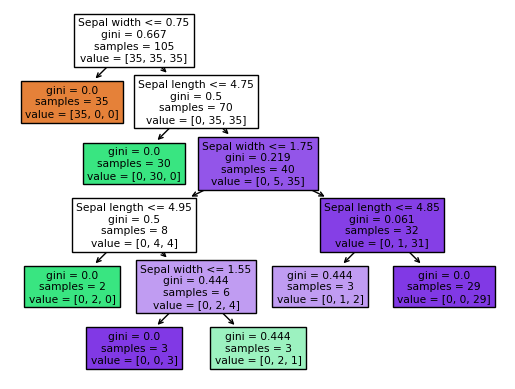

In [55]:
from sklearn import tree

feature_names = ['Sepal length', 'Sepal width',
                 'Petal length', 'Petal width']
tree.plot_tree(tree_model,
               feature_names=feature_names,
               filled=True)

plt.show()

Regarding the feature splitting criterion at each node, note that the branches to the left correspond to “True” and branches to the right correspond to “False.”

Looking at the root node, it starts with 105 examples at the top. The first split uses a sepal width cutoff $\leq 0.75$ cm for splitting the root node into two child nodes with 35 examples (left child node) and 70 examples (right child node). 


After the first split, we can see that the left child node is already pure and only contains examples from the `Iris-setosa` class (Gini impurity = 0). 

The further splits on the right are then used to separate the examples from the `Iris-versicolor` and `Iris-virginica` class.

Looking at this tree, and the decision region plot of the tree, we can see that the decision tree does a very good job of separating the flower classes.

Unfortunately, scikit-learn currently does not implement functionality to manually post-prune a decision tree. 

However, we could go back to our previous code example, change the `max_depth` of our decision tree to 3, and compare it to our current model.

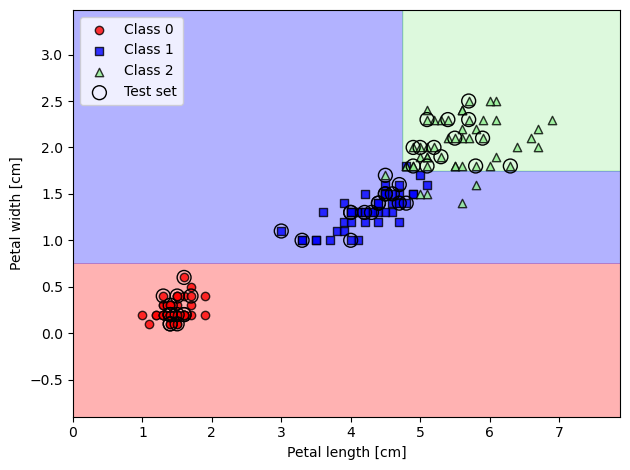

In [56]:
tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=3, 
                                    random_state=1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_model,
                      test_idx=range(105, 150))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

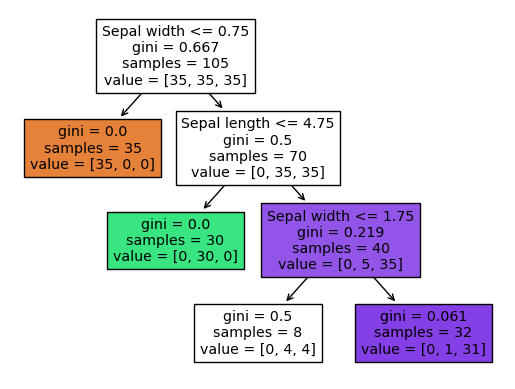

In [15]:
feature_names = ['Sepal length', 'Sepal width',
                 'Petal length', 'Petal width']
tree.plot_tree(tree_model,
               feature_names=feature_names,
               filled=True)

plt.show()

## Combining multiple decision trees via random forests

Ensemble methods have gained huge popularity in applications of machine learning during the last
decade due to their good classification performance and robustness toward overfitting. We will cover different ensemble methods, including **bagging** and **boosting** in our next lecture.

Let us discuss the decision tree-based **random forest** algorithm, which is known for its good scalability and ease of use. 

A random forest can be considered as an **ensemble** of decision trees. 

The idea behind a random forest is to average multiple (deep) decision trees that individually suffer from high variance to build a more robust model that has a better generalisation performance and is less susceptible to overfitting. 

The random forest algorithm can be summarized in four simple steps:

1. Draw a random **bootstrap** sample of size $n$ (randomly choose $n$ examples from the training
dataset with replacement).
2. Grow a decision tree from the bootstrap sample. At each node:

    a. Randomly select $d$ features without replacement.
    
    b. Split the node using the feature that provides the best split according to the objective function, for instance, maximising the information gain.


3. Repeat steps 1-2 $k$ times.
4. Aggregate the prediction by each tree to assign the class label by **majority vote**. Majority voting will be discussed in the next lecture.

Although random forests do not offer the same level of interpretability as decision trees, a big advantage of random forests is that we do not have to worry so much about choosing good hyperparameter values.

We typically do not need to prune the random forest since the ensemble model is quite robust to noise
from averaging the predictions among the individual decision trees. 

The only parameter that we need to care about in practice is the number of trees, $k$, (step 3) that we choose for the random forest.

Typically, the larger the number of trees, the better the performance of the random forest classifier
at the expense of an increased computational cost.

**Hyperparameter tuning:** Although it is less common in practice, other hyperparameters of the random forest classifier that can be optimise are the size, $n$, of the bootstrap sample and the number
of features, $d$, that are randomly chosen for each split. Via the sample size, $n$, of
the bootstrap sample, we control the bias-variance tradeoff of the random forest.

**Decreasing the size of the bootstrap sample** increases the diversity among the individual trees since
the probability that a particular training example is included in the bootstrap sample is lower. Thus,
shrinking the size of the bootstrap samples may increase the randomness of the random forest, and it can help to **reduce the effect of overfitting**.

However, smaller bootstrap samples typically result in a lower overall performance of the random forest and a small gap between training and test performance, but a low test performance overall.

Conversely, increasing the size of the bootstrap sample may increase the degree of overfitting. Because the bootstrap samples, and consequently the individual decision trees, become more similar to one another, they learn to fit the original training dataset more closely.

In most implementations, including the `RandomForestClassifier` implementation in `scikit-learn`, the
**size of the bootstrap sample** is chosen to be equal to the number of training examples in the original
training dataset, which usually provides a good bias-variance tradeoff.

**For the number of features, $d$**, at each split, we want to choose a value that is smaller than the total number of features in the training  dataset. A reasonable default that is used in scikit-learn and other implementations is $d = \sqrt{m}$ , where $m$ is the number of features in the training dataset.

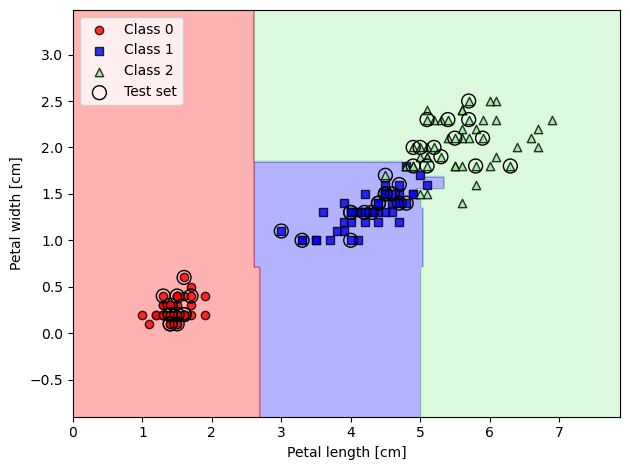

In [60]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Anbove, we trained a random forest from 25 decision trees via the `n_estimators`
parameter. 

By default, it uses the Gini impurity measure as a criterion to split the nodes. 

Although we are growing a very small random forest from a very small training dataset, we used the `n_jobs` parameter for demonstration purposes, which allows us to parallelise the model training using multiple cores of our computer (here, we set it to two cores).

## Using random forest to predict credit defaults

In [61]:
#Load the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.colors as colors
import matplotlib.pyplot as plt


# Import the data set
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls', header=1)


### Explore the dataset

In this task we predict the probability of a customer defaulting on a loan. The target variable is "default payment" (Yes=1; No=0). Details of the data measurements can be found in [UCI's data repository](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

In [18]:
#Explore the first ten rows of the data set
df.head(10)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


Each row represents an individual. Some columns that could be useful are credit limit, prior payment status, bill and payment amounts, and our target variable that indicates default next month.

In [19]:
# Rename the columns
df.rename({'default payment next month': 'DEFAULT'}, axis='columns', inplace=True)

#Remove the ID column as it is not informative
df.drop('ID', axis=1, inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Analyse missing data

One key step is to check for null values or other invalid input that will cause the model to throw an error. This is where referencing the data dictionary will be useful, so you know what is valid for a given data set.

In [20]:
# check dimensions for invalid values
print(df['SEX'].unique())
print(df['MARRIAGE'].unique())
print(df['EDUCATION'].unique())
print(df['AGE'].unique())

# count missing or null values
print(len(df[pd.isnull(df.SEX)]))
print(len(df[pd.isnull(df.MARRIAGE)]))
print(len(df[pd.isnull(df.EDUCATION)]))
print(len(df[pd.isnull(df.AGE)]))

#count of missing data
len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)]) #output: 68

[2 1]
[1 2 3 0]
[2 1 3 5 4 6 0]
[24 26 34 37 57 29 23 28 35 51 41 30 49 39 40 27 47 33 32 54 58 22 25 31
 46 42 43 45 56 44 53 38 63 36 52 48 55 60 50 75 61 73 59 21 67 66 62 70
 72 64 65 71 69 68 79 74]
0
0
0
0


68

The output indicates that some of the data does not align with the data definitions, specifically `EDUCATION` and `MARRIAGE` columns. 

`EDUCATION` includes three types of invalid values, which are 0, 5, and 6. 

`MARRIAGE` includes 0 as an invalid value. 

We assume that a 0 encoding is supposed to represent missing data and that a value of 5 or 6 within EDUCATION is representative of other unspecified education levels which is not represented within the data definition.

68 rows exist in the DataFrame where either the `EDUCATION` or the `MARRIAGE` column is zero. 

Next, we filter the rows where the `EDUCATION` and `MARRIAGE` columns have non-zero values.

In [21]:
#Filter the DataFrame
df_no_missing_data = df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]
df_no_missing_data.shape

(29932, 24)

The code above creates a new `DataFrame` with the missing values for `EDUCATION` and `MARRIAGE` removed.

The next step is to check whether the target variable, whether or not someone defaulted, is balanced.

C:\Users\aa261w\AppData\Local\Temp\ipykernel_29796\3188978421.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = df_no_missing_data['DEFAULT'], palette = 'dark')


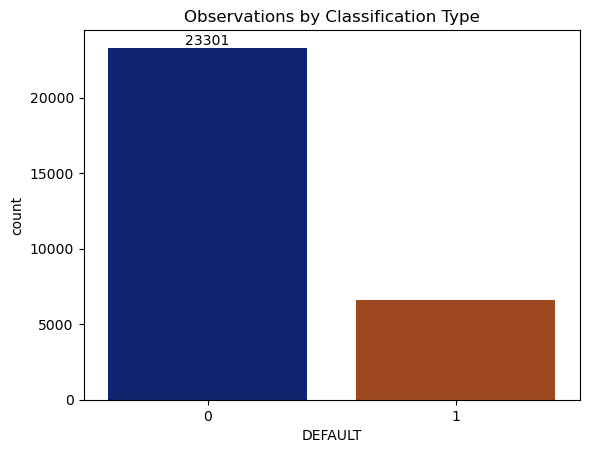

In [22]:
# Explore distribution of data set
# count plot on ouput variable

ax = sns.countplot(x = df_no_missing_data['DEFAULT'], palette = 'dark')
ax.bar_label(ax.containers[0])

# add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

The above chart shows counts of people who have defaulted (1) and haven't defaulted (0). Unsurprisingly, most people have not defaulted on their loans. To address this class imbalance, we will need to down sample the data.

### Downsample the dataset

The first step in downsampling is to split the data based on those who defaulted on their loan and those who did not default on their loan. 

For this demonstration, we randomly select 2000 samples from each category. 

In practice, a better method is to make sure the sample is balanced across all potentially biased variables, such as SEX, AGE, and MARRIAGE status. 

The two data sets are then merged back together for analysis.

In [23]:
from sklearn.utils import resample

# split data
df_no_default = df_no_missing_data.loc[(df_no_missing_data['DEFAULT']==0)]
df_default = df_no_missing_data.loc[(df_no_missing_data['DEFAULT']==1)]

# downsample the data set
df_no_default_downsampled = resample(df_no_default, replace=False, n_samples=2000, random_state=42 )
df_default_downsampled = resample(df_default, replace=False, n_samples=2000, random_state=42 )

#check ouput
len(df_no_default_downsampled)
len(df_default_downsampled)

# merge the data sets
df_downsample = pd.concat([df_no_default_downsampled, df_default_downsampled ])
df_downsample.shape

(4000, 24)

### Hot encode the independent variables

As `scikit-learn` does not support categorical data, we need to convert each categorical category into a binary variable with a value of 0 or 1. Once this change is made, the model should not treat the data as continuous. Pandas has a very convenient function to do just this, called `get_dummies`.

One thing to keep in mind when creating models is to avoid bias. One very important way to do this is to not use variables associated with protected attributes as independent variables. In this case, `SEX`, `AGE`, and `MARRIAGE` clearly fall into that category. `EDUCATION` is somewhat more ambiguous. 

In [24]:
# isolate independent variables
Y = df_downsample.drop(['DEFAULT','SEX', 'EDUCATION', 'MARRIAGE','AGE'], axis=1).copy()

X_encoded = pd.get_dummies(data=Y, columns=['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])
X_encoded.head()

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000,100143,50456,50000,0,0,0,2500,1000,0,...,False,True,False,False,False,False,False,False,False,False
4678,170000,165027,168990,172307,35234,32869,33862,7200,7500,1200,...,False,False,False,True,False,False,False,False,False,False
16004,180000,25781,26000,26310,26662,26166,26176,1800,1800,1500,...,False,False,False,True,False,False,False,False,False,False
22974,210000,355,975,410,0,0,0,979,412,0,...,False,True,False,False,False,False,False,False,False,False
17535,190000,76433,78472,80548,81778,83082,84811,3300,3331,3359,...,False,False,False,True,False,False,False,False,False,False


It is generally a good idea to normalise your data, but for random forest models on classification tasks, normalisation is not necessary.

### Split the data set

In [25]:
from sklearn.preprocessing import scale
y = df_downsample['DEFAULT'].copy()
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

###  Classify accounts and model evaluation

We plot the evaluation using a confusion matrix.

Accuracy: 72.50%


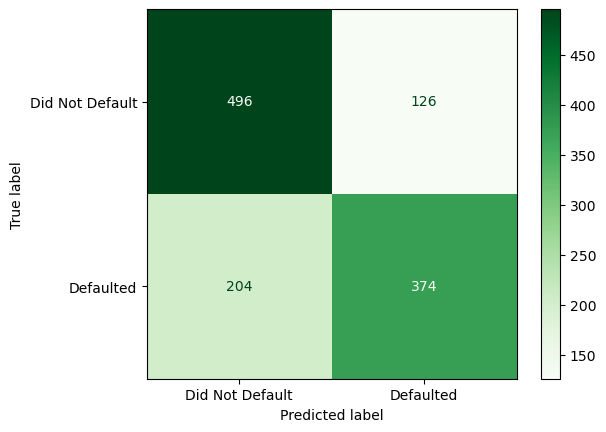

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

clf_rf = RandomForestClassifier(max_depth=3, random_state=0)
clf_rf.fit(X_train, y_train)

#calculate overall accuracy
y_pred = clf_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')

class_names = ['Did Not Default', 'Defaulted']
disp = ConfusionMatrixDisplay.from_estimator(
        clf_rf,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Greens)

As we can see, the model performance could be improved. Of the $622$ $(496+126)$ accounts that did not default, only $79.75\% (496)$ were correctly predicted. Of the $578$ $(204+374)$ accounts that did default, only $64.70\% (374)$ were correctly predicted.

### Hyperparameter tuning

When it comes to random forest models, we can find the best hyperparameters by looking `max_depth`, `min_samples_split`, `min_samples_leaf`, and `max_leaf_nodes`. Here is what they mean:

- `max_depth`: the maximum number levels the decision trees that make up the random forest are allowed to have
- `min_samples_split`: the minimum number of samples that must be in a node for a decision split to be allowed
- `min_samples_leaf`: the minimum number of samples that must exist in a leaf node

Larger numbers on `min_samples_split` and `min_samples_leaf`, and smaller numbers on `max_depth` help avoid overfitting.

Other hyperparameters that can be optimised are: 

- `max_features`: the number of features a model tries out when attempting to create a decision node
- `n_estimators`: controls the number of decision trees that are created as part of the random forest model

In [39]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth':[2,3,4,5,6],
    'min_samples_split':[2,3,4,5,6],
    'min_samples_leaf':[2,3,4,5,6]
}
rf_random = RandomizedSearchCV(
    estimator = clf_rf, param_distributions = param_grid, 
    n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 5}


Accuracy: 72.92%


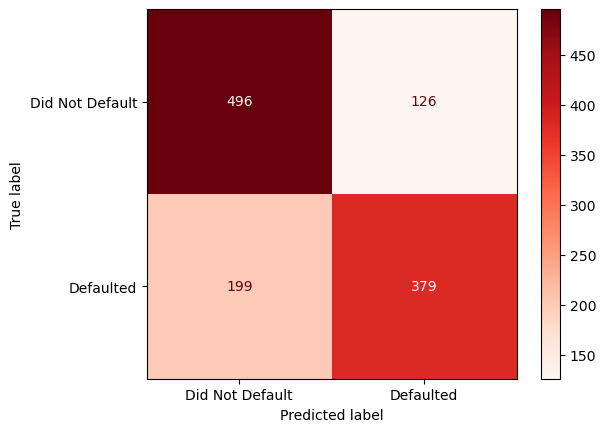

In [42]:
# refit model with optimal hyperparameters
clf_rf = RandomForestClassifier(
    max_depth=5, min_samples_split=3, min_samples_leaf=2,
    random_state=0)
clf_rf.fit(X_train, y_train)

#calculate overall accuracy
y_pred = clf_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2%}')

# plot confusion matrix
class_names = ['Did Not Default', 'Defaulted']
disp = ConfusionMatrixDisplay.from_estimator(
        clf_rf,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Reds)